In [2]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from pymongo import MongoClient

In [24]:
# Connexion à MongoDB et chargement des données
client = MongoClient("localhost", 27017)
db = client.IF29
collec = db.user_db_pca
data = pd.DataFrame(list(collec.find()))
sample_data = data.sample(frac=0.03, random_state=42)

In [25]:
cah = linkage(sample_data, method="ward")
print(cah)

MemoryError: Unable to allocate 11.4 GiB for an array with shape (1529183253,) and data type float64

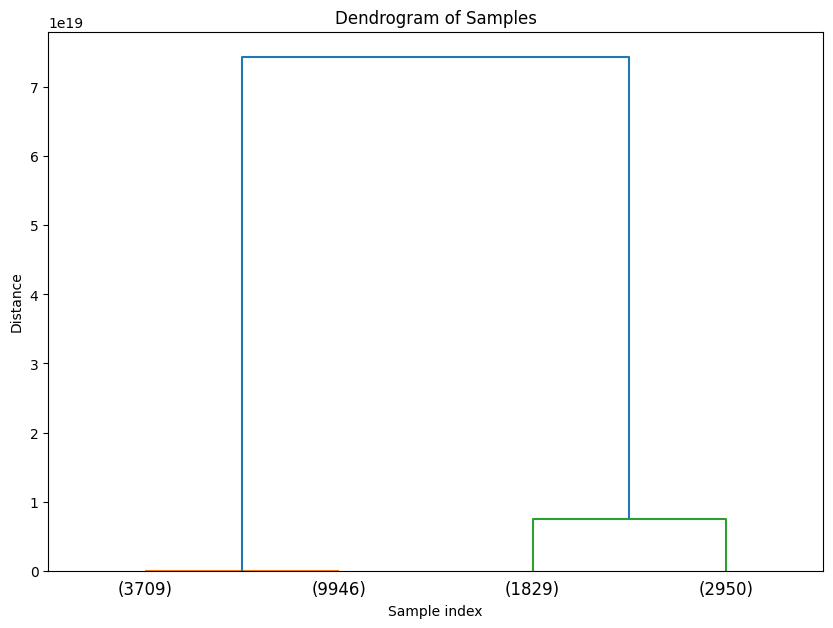

In [21]:
# Dendrogramme des échantillons
plt.figure(figsize=(10, 7))
dendrogram(cah, truncate_mode="level", p=10)
plt.title('Dendrogram of Samples')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

In [6]:
from sklearn.metrics import silhouette_score
# Fonction pour trouver le meilleur seuil max_d
def optimal_dendrogram_cut(cah, pca_res, min_clusters=2, max_clusters=10):
    best_silhouette_score = -1
    best_num_clusters = 0
    best_clusters = None

    for num_clusters in range(min_clusters, max_clusters + 1):
        # Utiliser fcluster pour couper le dendrogramme à num_clusters
        clusters = fcluster(cah, num_clusters, criterion='maxclust')
        
        # Calculer le score de silhouette pour les clusters
        silhouette_avg = silhouette_score(pca_res, clusters)
        
        # Comparer et garder le meilleur score de silhouette
        if silhouette_avg > best_silhouette_score:
            best_silhouette_score = silhouette_avg
            best_num_clusters = num_clusters
            best_clusters = clusters
            
    return best_num_clusters, best_clusters, best_silhouette_score

In [16]:
# Trouver le meilleur nombre de clusters
best_num_clusters, best_clusters_hierarchical, best_silhouette_score = optimal_dendrogram_cut(cah, sample_data)

print(f'Best number of clusters: {best_num_clusters}')
print(f'Best silhouette score: {best_silhouette_score}')

Best number of clusters: 2
Best silhouette score: 0.9668135014348278


In [ ]:
# Détermination du nombre de clusters en coupant le dendrogramme à une distance spécifiée
max_d = best_clusters_hierarchical  # Ajustez cette distance en fonction de votre analyse
data['cluster_label'] = fcluster(cah, max_d, criterion='distance')

# Affichage des clusters
plt.scatter(sample_data["pca0"], sample_data["pca1"], c=sample_data['cluster_label'], s=0.5, cmap='viridis')
plt.title('Clusters déterminés par CAH')
plt.xlabel('Première composante principale')
plt.ylabel('Deuxième composante principale')
plt.colorbar(label='Cluster label')
plt.show()

In [ ]:
# Charger les données de la base de données B pour la mise à jour
db_B = client['IF29']
collection_B = db_B['user_db']

# Mettre à jour les documents de la base de données B avec les étiquettes de cluster
for index, row in sample_data.iterrows():
    id_value = row['_id']
    cluster_label = int(row['cluster_label'])  # Convertir en int si nécessaire
    collection_B.update_one({'_id': id_value}, {'$set': {'cah': cluster_label}})